*SMTB-2021: A Glimpse into Algorithms | Alexey Bochkarev* ([🖂](mailto:a@bochkarev.io), [🌐](https://www.bochkarev.io/contact))

# Where we are? <a class="tocSkip">
- Welcome!
- Course [outline](./README.org) and logistics/tech.
  + ✅ **Topic 1:** we will try *designing* algorithms, taking sorting problem as an example (and using several approaches you might have heared about).
  + ✅ **Topic 2:** we will discuss more systematically how to compare algorithms, focusing on the concept of runtime.
  + 👉 **Topic 3:** DP + example "bio-" algorithm (global alignment),
  + **Topic 4:** let's talk data structures.

**So,** we know how to characterize algorithms:
- correctness,
- worst-/average-/best-case runtimes,
- big O notation (and friends),
- memory requirements.

(and know there are "hard" problems, and there are limits to what we can achieve.)

Let us just consider a couple of specific, more complex examples.

## Today, Topic 3:
- **Dynamic programming** technique for designing algorithms
- **Needleman-Wunsch** algorithm as an example

In [1]:
# we'll need this today:
from time import time
from math import log
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

## Dynamic programming: a simple example

Consider a classical problem.

- You have coins, 1, 10, and 25 cents (as many as necessary)
- **The problem:** make $C$ cents in change, using as few coins as possible.

**Any ideas** how to solve this?

- **greedy:** always use the largest available coin.

However: $C$ = 34 cents. 
- Greedy gives: 1 x (25) + 9 x (1) = 10 coins
- But we could do 3 x (10) + 4 x (1) = 7 coins!

**Alternatively:** exhaustive search.
- consider all first-step decisions,
- recursively do with the second step,
- ...

In [2]:
def min_coins(C):
    """Solves the problem with exhaustive search."""
    current_min = -1
    
    for next_coin in [1,10,25]:
        if C - next_coin < 0:
            break
            
        best_no_coins = min_coins(C - next_coin)
        
        if current_min==-1 or best_no_coins < current_min:
            current_min = best_no_coins
    
    return current_min + 1

In [3]:
min_coins(34)

7

What's the problem with this implementation?

In [4]:
def get_runtimes(C, solve_func):
    """Calculates the runtime in seconds, for C."""
    t0 = time()
    solve_func(C)
    t1 = time()
    return t1-t0

def runtimes_figure(solve_func, plt_color='r-', plt_label="min_coins"):
    """Makes a plot of runtimes."""
    Cmin = 50; Cmax = 80
    runtimes = [get_runtimes(C, solve_func) for C in range(Cmin,Cmax)]
    
    plt.rcParams.update({'font.size': 28})
    plt.xticks(rotation=90)
    plt.plot([C for C in range(Cmin,Cmax)], runtimes, plt_color, label=plt_label)
    plt.gca().set(xlabel='Problem parameter, C', ylabel='Runtimes, sec')
    plt.legend(fontsize=28)

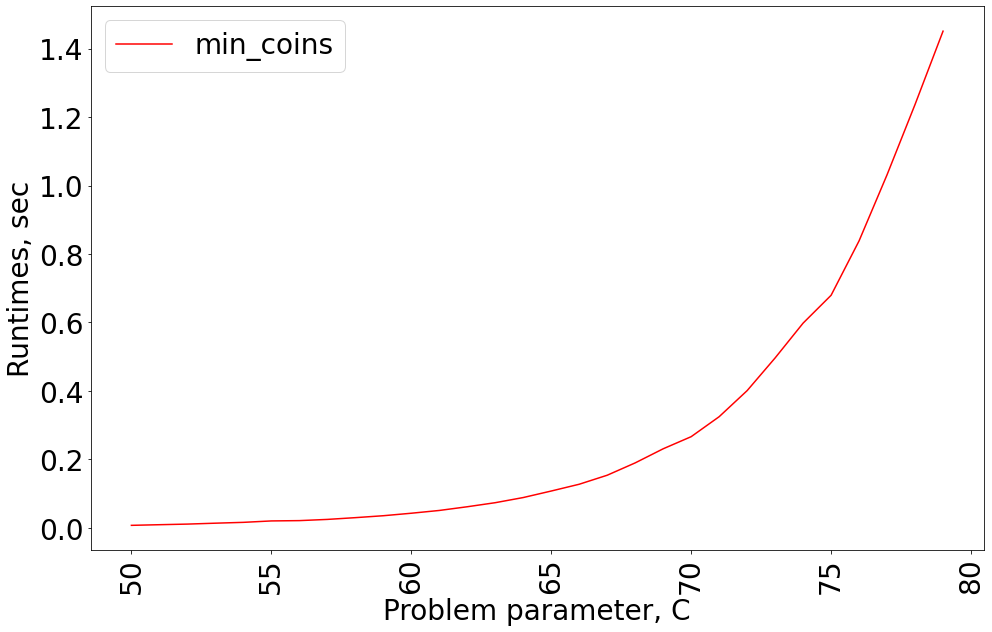

In [5]:
plt.figure(figsize = (16,10)); 
runtimes_figure(min_coins)

🤦 Ok, let's try to figure out if we can improve it...

In [6]:
calls = {}

def min_coins_debug(C):
    """Solves the problem with exhaustive search."""
    global calls
    if C in calls.keys():  # +---
        calls[C] += 1      # | So, this part
    else:                  # | is new: counting calls.
        calls[C] = 1       # +---
        
    current_min = -1

    for next_coin in [1,10,25]:
        if C - next_coin < 0:
            break
            
        best_no_coins = min_coins_debug(C - next_coin)
        
        if current_min==-1 or best_no_coins < current_min:
            current_min = best_no_coins
    
    return current_min + 1

In [7]:
calls = {}
min_coins_debug(34)

print("Summary of calls to `min_coins`:")

for C in calls.keys():
    print(f"with C={C:2d}: {calls[C]:3d} times")

Summary of calls to `min_coins`:
with C=34:   1 times
with C=33:   1 times
with C=32:   1 times
with C=31:   1 times
with C=30:   1 times
with C=29:   1 times
with C=28:   1 times
with C=27:   1 times
with C=26:   1 times
with C=25:   1 times
with C=24:   2 times
with C=23:   3 times
with C=22:   4 times
with C=21:   5 times
with C=20:   6 times
with C=19:   7 times
with C=18:   8 times
with C=17:   9 times
with C=16:  10 times
with C=15:  11 times
with C=14:  13 times
with C=13:  16 times
with C=12:  20 times
with C=11:  25 times
with C=10:  31 times
with C= 9:  39 times
with C= 8:  48 times
with C= 7:  58 times
with C= 6:  69 times
with C= 5:  81 times
with C= 4:  95 times
with C= 3: 112 times
with C= 2: 133 times
with C= 1: 159 times
with C= 0: 191 times


Aha! Here's an obvious problem! What do we do?

Let's maybe just save all the subproblem solutions as we go?

In [8]:
_subproblems = {}

def min_coins_smarter(C, initial_call = True):
    """Solves the problem saving subproblems along the way."""
    global _subproblems  # not a really good kung-fu, but would work
    current_min = -1
    
    if initial_call:
        _subproblems = dict()

    if C in _subproblems.keys():
        return _subproblems[C]
    
    for next_coin in [1,10,25]:
        if C - next_coin < 0:
            break
            
        if (C - next_coin) in _subproblems.keys():
            best_no_coins = _subproblems[C-next_coin]
        else:
            best_no_coins = min_coins_smarter(C - next_coin, initial_call = False)
            _subproblems[C - next_coin] = best_no_coins
        
        if current_min==-1 or best_no_coins < current_min:
            current_min = best_no_coins
    
    return current_min + 1

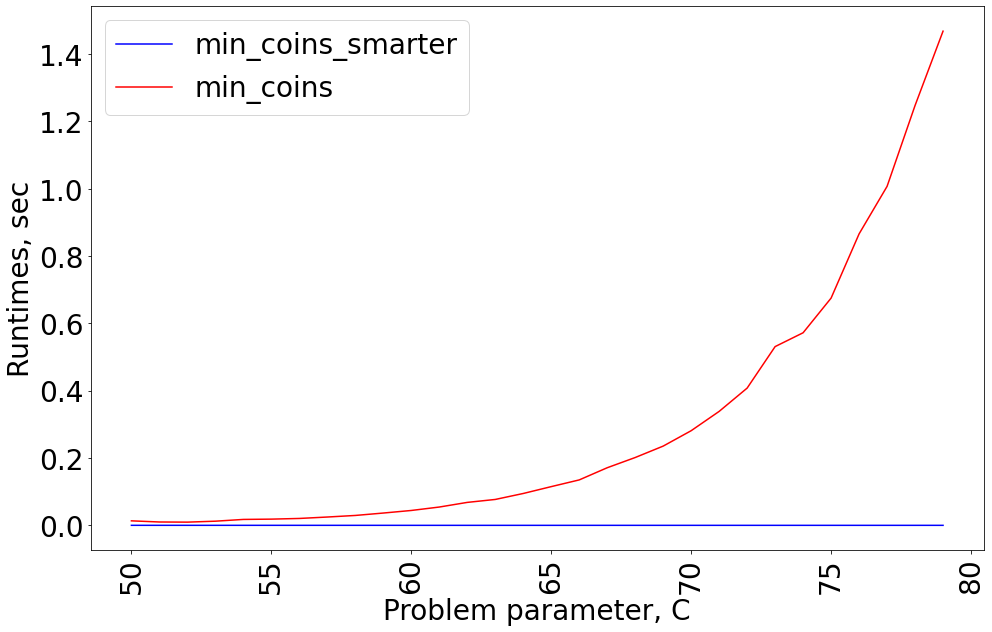

In [9]:
plt.figure(figsize = (16,10))
runtimes_figure(min_coins_smarter, "b-", "min_coins_smarter")
runtimes_figure(min_coins, "r-", "min_coins")

Is it a mistake? A typo in the code somewhere, so it does not run?

In [10]:
%time min_coins(80)

CPU times: user 1.79 s, sys: 28 µs, total: 1.79 s
Wall time: 1.79 s


5

In [11]:
%time min_coins_smarter(80)

CPU times: user 117 µs, sys: 1 µs, total: 118 µs
Wall time: 123 µs


5

Okay, are the answers correct indeed?

In [12]:
def cross_check(func_1, func_2):
    """Checks that two approaches give the same result."""
    print("[", end="")
    for C in range (10,70):
        if func_1(C) == func_2(C):
            print(".", end="")
        else:
            print(f"ERROR for C={C}")

    print("] done")
    
cross_check(min_coins, min_coins_smarter)

[............................................................] done


🎉🎉🎉

### What has happened?
We can think about the problem sort of *backwards*:

Let $m(C)$ be an optimal number of coins to make $C$ in change. Then:

\begin{equation*}
m(C)=1+\min\{m(C-1), m(C-10), m(C-25)\}.
\end{equation*}

(Technically, we'd need to add that $m(0)=0$ and $m(C)=+\infty$ for $C<0$.)

So, in principle, we could implement it the other way around. For convenience, let me rephrase the condition above as follows:
- define an array of $M(c)$-s, $c=1,\ldots,C$, so that
- $M(c)$ would mean "optimal number of coins I need to make $C$ in change (in total) **if I already have** $c$.
- then $M(c) = 1 + min\{M(c+1),~M(c+10),~M(C+25)\}$.
- (Again, assuming $M(c)=+\infty$ for $c>C$.)

So, since we know $M(C)=0$ (we already have what we need!), we can just fill the whole array in backwards! Also, this way it is obvious that the runtime is $O(C)$.

This is a classical example of **"Dynamic Programming"** approach (R.E. Bellman 1953): think, decomposing the problem into smaller sub-problems sort-of-recursively.

In [13]:
def min_coins_DP(C):
    """Implements a DP approach for the problem."""
    M = [0 for c in range(C+1)]
    INF = 2*C  # I will treat this number as infinity
    
    for c in reversed(range(C)):
        M[c] = 1 + min([ M[c + coin] 
                      if (c + coin) <= C else INF 
                      for coin in [1, 10, 25]
                     ])
    return M[0]

min_coins_DP(34)

7

In [14]:
cross_check(min_coins_smarter, min_coins_DP)

[............................................................] done


Of course, the time is linear in $C$: if runtime $T(C)=\alpha C + \beta$, where $\alpha$ and $\beta$ are some constants, then 
$$T(C+1) - T(C) = \alpha ((C+1) - C) = \alpha= \textrm{Const},$$
which we can just check numerically:

(-0.005, 0.005)

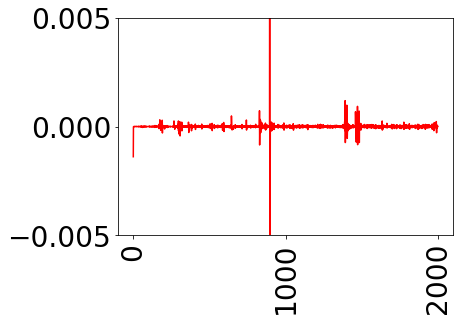

In [15]:
Cmin = 1; Cmax = 2000
runtimes = [get_runtimes(C, min_coins_DP) for C in range(Cmin,Cmax)]

dTs = [runtimes[i+1] - runtimes[i] for i in range(Cmax-Cmin-1)]

plt.rcParams.update({'font.size': 28})
plt.xticks(rotation=90)
plt.plot([C for C in range(Cmin, Cmax-1)], dTs, 'r-', label="runtime coefficient")
plt.ylim(-0.005,0.005)

### How to reconstruct a solution, though?

### Bottomline:
- DP basically means decomposing the problem recursively into subproblems,
- so that it would be easy to solve them in certain order. (Because at each step we would know the solutions to part of the subproblems, and we could re-use many of them several times.)
- usually, we reconstruct a solution by making another pass (or just saving things as we go)

**Note:** 
- our previous implementation solved the same subproblems, so 
- it was in fact an implementation of DP as well. 

(This is something called *memoization* -- when you save and re-use your intermediary subproblems results).

- Designing such algorithms, and actually recognizing algorithms that can be solved with DP just takes practice.
- (basically, any algorithms textbook would help; see, e.g.,  this course [summary](./README.org))

## An application: Needleman-Wunsch algorithm

OK, let's just look at an example of a DP algorithm.

**Disclaimer:** I am not an expert on the underlying biology, or bioinformatics (luckily, you have many such people around on the School!). 

So, I will be discussing a very basic version of the algorithm, and almost entirely from a CS perspective -- as an illustration of DP approach. There is state of the art is far, far away already; however, you are on a good track to catch up!

### The problem: align protein / nucleotide sequences
Assume we have two sequences:

    A = TGGTG
    B = ATCGT
... and we would like to compare them.

**The trouble is:** the life has been happening, so we need to *align* these two strings, by inserting "spaces" (which are called *indels*, INsertions or DELetions).

### Scoring
For each pair of letters after the alignment, we assign scores, such as:

         v     
    GCAT|G|-CU
    G-AT|T|ACA   
         ^
we can have either of the following situations:
- a match (score `+1`)
- a mismatch (score `-1`)
- an indel (score `-2`)

E.g., this alignment above would yield:

    GCATG-CU
    G-ATTACA
    +I++-I+- = -2
(Again: there are several approaches to assign scores, and there are several algorithms in general, but let us discuss this one.)

**The problem:** how to find a best alignment then, if we are allowed to insert a "space" anywhere we like?

**An answer:** let's try DP!

And the key to DP is to choose the right function that will track the objective and allow for problem decomposition (which was $M(C)$ in the previous example). Let's do it as follows.

Consider a table, with rows corresponding to the letters of the first sequence, and columns -- to the second one (adding an artificial "space" in the beginning of both):

![Mtable](img/NW_table.png)

**First: we know how to initialize it!**

![Mtable](img/NW_table_init.png)

![Mtable](img/NW_table_step.png)

Well, given that
$$M_{ij} = \max\{M_{i-1,j-1}+S_{i,j}, M_{i-1,j}+d, M_{i,j-1}+d\},$$
where $S_{i,j}$ is a (mis)match score for sequences elements $i$ and $j$, and $d$ is a gap penalty -- the rest is easy:

In [22]:
def NW_calculate_M(A, B, match_score, mismatch_score, d):
    """(Globally) aligns two sequences.
    
    Args:
        A, B (str): sequences to align,
        match_score, mismatch_score, d (float): scoring scheme.
        
    Returns:
        Matrix M.
    """
    M = [[0.0 for j in range(len(B)+1)] for i in range(len(A)+1)]
    
    # Initialization
    for i in range(len(A)+1):
        M[i][0] = i*d
    
    for j in range(len(B)+1):
        M[0][j] = j*d
        
    # Filling in the matrix
    for j in range(1, len(B)+1):
        for i in range(1, len(A)+1):
            if A[i-1] == B[j-1]:
                match_term = match_score
            else:
                match_term = mismatch_score
                
            M[i][j] = max([ M[i-1][j-1] + match_term,
                         M[i-1][j]+d,
                         M[i][j-1]+d])
    
    return M

In [23]:
A = "ATCGT"
B = "TGGTG"

M = NW_calculate_M("ATCGT", "TGGTG", +1, -1, -2)
 
pd_M = pd.DataFrame(M)
pd_M.index = ["-"]+[x for x in A]
pd_M.columns = ["-"]+[x for x in B]

print(pd_M)
print(f"\nOptimal score is (bottom right number): {np.array(M)[5][5]}")

    -  T  G  G  T   G
-   0 -2 -4 -6 -8 -10
A  -2 -1 -3 -5 -7  -9
T  -4 -1 -2 -4 -4  -6
C  -6 -3 -2 -3 -5  -5
G  -8 -5 -2 -1 -3  -4
T -10 -7 -4 -3  0  -2

Optimal score is (bottom right number): -2


### And how to recover a solution?
Well, we can just make a backward pass! (breaking ties arbitrarily, if we do not care about alternative optima)

In [24]:
def recover_alignment(A, B, match_score, mismatch_score, d, M):
    """Recovers an optimal alignment."""
    Ap = ""; Bp = ""
    
    i = len(A)-1; j = len(B)-1
    
    while (i >= 0) or (j >= 0):
        if A[i] == B[j]:
            match_term = match_score
        else:
            match_term = mismatch_score
            
        if (i >= 0) and (j >=0) and \
            M[i+1][j+1] == M[i][j] + match_term:
            Ap = A[i] + Ap 
            Bp = B[j] + Bp
            i -= 1; j -= 1
            
        elif (i >= 0) and M[i+1][j+1] == M[i][j+1] + d:
            Ap = A[i] + Ap
            Bp = "‒" + Bp
            i -= 1
        else:
            Ap = "‒" + Ap
            Bp = B[j] + Bp
            j -= 1
            
    return Ap, Bp

In [25]:
def my_NW(A,B):
    """Prints the alignment results for A and B."""
    M = NW_calculate_M(A,B,+1, -1, -2)
    Ap, Bp = recover_alignment(A,B, +1, -1, -2, np.array(M))
    print("Before the alignment:")
    print(f"A = {A}")
    print(f"B = {B}")
    print("***\nAfter the alignment:")
    print(f"A'= {Ap}")
    print(f"B'= {Bp}")
    print(f"***\nOptimal score: {M[-1][-1]}")

In [26]:
my_NW("ATCGT", "TGGTG")

Before the alignment:
A = ATCGT
B = TGGTG
***
After the alignment:
A'= ATCGT‒
B'= ‒TGGTG
***
Optimal score: -2


In [27]:
my_NW("TGCATGAAAGGCCGTG", "CAATAAGCGTCAAACTGC")

Before the alignment:
A = TGCATGAAAGGCCGTG
B = CAATAAGCGTCAAACTGC
***
After the alignment:
A'= TGCATGAAAGGC‒‒CGTG‒
B'= ‒CAATAAGCGTCAAACTGC
***
Optimal score: -9


### A concluding note
- again, the state of the art is far ahead --- ask around if interested!
- but I think this is a nice example of a practically useful application of Dynamic Programming!

### Also, a question to think about with ☕:

recalling that
$$M_{ij} = \max\{M_{i-1,j-1}+S_{i,j}, M_{i-1,j}+d, M_{i,j-1}+d\},$$
where $S_{i,j}$ is a (mis)match score for sequences elements $i$ and $j$, and $d$ is a gap penalty

> **how fast is the algorithm**, in terms of $|A|$ and $|B|$ (and Big-O notation)?..

OK, we considered two examples: coins & change (a "toy" one) and Needleman-Wunsch (a "real" one).

### Take-aways
- DP basically means decomposing the problem recursively into subproblems,
- so that it would be easy to solve them in certain order. 
- (Because at each step we build up a solution for a bigger subproblem from the smaller ones)
- usually, we reconstruct a solution by making another pass (or just saving things as we go)
- DP can be implemented in several ways, bottom-up or top-down.
- sometimes it helps